Libraries to intstall to use GEE in colab

In [ ]:
!pip install ipyleaflet==0.17
!pip install eemont
!pip install rasterio
!pip install earthpy

In [ ]:
import ee
import eemont
import geemap as geemap
import os
import math
import rasterio
from rasterio.windows import Window
import folium
import earthpy.plot as ep
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # statistical data visualization
import tensorflow as tf
import keras
from keras import Sequential
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from keras import Model

import sklearn.model_selection
from keras.utils import to_categorical, plot_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier



GEE authentication

In [ ]:
ee.Authenticate()
ee.Initialize(project='ee-andreagonnelli06')
# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'

print('Folium version: ' + folium.__version__)


Folium version: 0.14.0


Project area GEOjson conversion in feature collection to clip the image collections or the images used to estimate the AGB.

In [ ]:
geojson = {"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"geometry":{"coordinates":[[12.78632055620858,42.18169545297127],[12.786010513010382,42.1814090541948],[12.785883097998038,42.18145626287344],[12.785475369956941,42.181843372711114],[12.785556066131477,42.18189687550978],[12.785161079591404,42.18210459183089],[12.785233281432284,42.18214235836135],[12.786010513010382,42.18176469204164],[12.786307814706504,42.18174895589581],[12.786329050542236,42.18169545297127]],"type":"LineString"}}]}
area = ee.FeatureCollection(geojson)


In [ ]:
Map = geemap.Map(toolbar_ctrl=True, layer_ctrl=True)
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
rectangle=Map.draw_last_feature
rectangle.getInfo()
geometria=rectangle.geometry().getInfo()

coordinates=geometria['coordinates'][0]
coordinates1=coordinates[0]
coordinates2=coordinates[2]


In [ ]:
rectangles = ee.Geometry.Rectangle([coordinates1, coordinates2])
def clippa(image):
  return image.clip(rectangles)

Sentinel-1 download and filtering

In [ ]:
S1_PRS = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filterDate('2021-04-01', '2021-06-30')\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))\
    .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))\
    .filterBounds(rectangles)\
    .map(clippa);

Sentinel-1 preprocessing and visualization

In [ ]:
S1_PRS_pc = S1_PRS.reduce(ee.Reducer.percentile([25,50,75]));
S1_PRS_pc = ee.Image(10).pow(S1_PRS_pc.divide(10));

S1_PRS_pc_Feats = S1_PRS_pc.select(['VH_p50','VV_p50']).clip(rectangles);
S1_PRS_pc_Feats = S1_PRS_pc_Feats.reproject(crs= 'EPSG:4326',scale= 30);

PRS_VV_iqr = S1_PRS_pc_Feats.addBands((S1_PRS_pc.select('VV_p75').subtract(S1_PRS_pc.select('VV_p25'))).rename('VV_iqr'));
PRS_VH_iqr = S1_PRS_pc_Feats.addBands((S1_PRS_pc.select('VH_p75').subtract(S1_PRS_pc.select('VH_p25'))).rename('VH_iqr'));
PRS_VV_iqr  = PRS_VV_iqr.float();
PRS_VH_iqr  = PRS_VH_iqr.float();

display('Post-rainy Season VV IQR', PRS_VV_iqr);

display('Post-rainy Season VV IQR', PRS_VH_iqr);

visvv = {'min': 0,'max': 0.1,'bands': 'VV_iqr'}
visvh = {'min': 0,'max': 0.1,'bands': 'VH_iqr'}

Map.addLayer(PRS_VV_iqr,visvv, 'Sentinel-1 IW VV');
Map.addLayer( PRS_VH_iqr,visvh, 'Sentinel-1 IW VH');

Map.centerObject(S1_PRS, 8)
Map


'Post-rainy Season VV IQR'

'Post-rainy Season VV IQR'

Map(bottom=12701.9462890625, center=[39.062522763678345, 16.35276127246959], controls=(WidgetControl(options=[…

Sentinel-2 cloudMasking and reflectance normalization.

In [ ]:
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED');

def  maskS2clouds(image):
  qa = image.select('QA60');

  cloudBitMask = ee.Number(2).pow(10).int();
  cirrusBitMask = ee.Number(2).pow(11).int();

  mask = qa.bitwiseAnd(cloudBitMask).eq(0)&(qa.bitwiseAnd(cirrusBitMask).eq(0))

  return image.updateMask(mask).divide(10000);

def calculate_indices(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4'),
            'BLUE': image.select('B2')
        }).rename('EVI')
    ndii = image.normalizedDifference(['B3', 'B8']).rename('NDII')
    return image.addBands([ndvi, evi, ndii])

composite = s2.filterDate('2021-04-01', '2021-06-30')\
                  .filterBounds(rectangles)\
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))\
                  .map(maskS2clouds)\
                  .map(calculate_indices)\
                  .map(clippa)\


S2_composite = composite.median().reproject(crs= 'EPSG:4326', scale= 30);
S2_composite = S2_composite.float()
S2_composite = S2_composite.select('B4','B5','B8','B11', 'B12','NDVI','EVI','NDII')
display(S2_composite)
vis_s2 = {'min': 0, 'max': 0.3, 'bands': ['B11', 'B8', 'B4']};

Map.addLayer(S2_composite, vis_s2, 'Sentinel-2');
Map.centerObject(S1_PRS, 8)
Map

Map(bottom=25332.0, center=[39.062522763678345, 16.35276127246959], controls=(WidgetControl(options=['position…

Set of the canopy Height Model

In [ ]:
canopy_ht = ee.ImageCollection("projects/meta-forest-monitoring-okw37/assets/CanopyHeight")\
.filterBounds(rectangles)\
.map(clippa)\
.select('cover_code')\
.first()\
.float()

canopy_ht=canopy_ht.reproject(crs= 'EPSG:4326', scale= 30)
Map.addLayer(canopy_ht, {'min': 0, 'max': 10, 'palette': ['blue', 'yellow', 'orange', 'red']}, 'Canopy Height');
Map.centerObject(S1_PRS, 8)
Map

Map(bottom=25332.0, center=[39.062522763678345, 16.35276127246959], controls=(WidgetControl(options=['position…

Set of the slope and elevation data

In [ ]:
SRTM = ee.Image("USGS/SRTMGL1_003");

elevation = SRTM.clip(rectangles);

elevation = elevation.reproject(crs='EPSG:4326',scale=30).float();
display(elevation)
slope = ee.Terrain.slope(SRTM).clip(rectangles);
display(slope)
slope = slope.reproject(crs='EPSG:4326',scale=30).float();

Map.addLayer(elevation, {'min': 0, 'max': 4000, 'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}, 'SRTM');
Map.addLayer(slope, {'min': 0, 'max': 90, 'palette': ['blue', 'yellow', 'orange', 'red']}, 'Slope');
Map.centerObject(S1_PRS, 8)
Map

Name,Description
elevation,Elevation


Map(bottom=25332.0, center=[39.062522763678345, 16.35276127246959], controls=(WidgetControl(options=['position…

Merging of the satellite data and bands definition

In [ ]:
bands = ['B4','B5','B8','B11', 'B12','NDVI','EVI','NDII', 'VV_iqr', 'VH_iqr', 'elevation', 'slope','cover_code','agbd'];


Preprocessing of GEDI data


In [ ]:
l4b = ee.ImageCollection('LARSE/GEDI/GEDI04_A_002_MONTHLY')\
.filterDate('2021-04-01', '2021-06-30')\
.filterBounds(rectangles)\
.median();

not_null = l4b.select('agbd').unmask()
aboveground = l4b.select('agbd')
maschera= aboveground.gt(0).mask()

# Applica il filtro all'immagine
dataset = aboveground.updateMask(maschera)
dataset=dataset.clip(rectangles).float();
display(dataset)

dataset1 = dataset.reproject(crs= 'EPSG:4326', scale=30);

Map.addLayer(dataset1,
    {'min': 10, 'max': 250, 'palette':['440154','414387','2a788e','23a884','7ad151','fde725']},
    'Mean Biomass');
Map.centerObject(S1_PRS, 8)
Map

Map(bottom=25332.0, center=[39.062522763678345, 16.35276127246959], controls=(WidgetControl(options=['position…

In [ ]:
mergedCollection = S2_composite.addBands(PRS_VV_iqr.addBands(PRS_VH_iqr.addBands(elevation.addBands(slope))).addBands(canopy_ht).addBands(dataset1));

mergedCollection

Conversion of the GEDI pixels in feature Collection to use as training and test datasets.

In [ ]:

ee.batch.Export.image.toDrive(
  image=mergedCollection.select(bands),
  description='mergedCollection5',
  scale=30,
  region=rectangles,
  maxPixels=1e13
).start()



In [ ]:
# Classify the reflectance image from the trained classifier.
img_classified = mergedCollection.classify(classifier)
vis_params = {'bands': ['classification'], 'palette': ['#440154', ' #440256', ' #450457', ' #450559', ' #46075a', ' #46085c', ' #460a5d', ' #460b5e', ' #470d60', ' #470e61', ' #471063', ' #471164', ' #471365', ' #481467', ' #481668', ' #481769', ' #48186a', ' #481a6c', ' #481b6d', ' #481c6e', ' #481d6f', ' #481f70', ' #482071', ' #482173', ' #482374', ' #482475', ' #482576', ' #482677', ' #482878', ' #482979', ' #472a7a', ' #472c7a', ' #472d7b', ' #472e7c', ' #472f7d', ' #46307e', ' #46327e', ' #46337f', ' #463480', ' #453581', ' #453781', ' #453882', ' #443983', ' #443a83', ' #443b84', ' #433d84', ' #433e85', ' #423f85', ' #424086', ' #424186', ' #414287', ' #414487', ' #404588', ' #404688', ' #3f4788', ' #3f4889', ' #3e4989', ' #3e4a89', ' #3e4c8a', ' #3d4d8a', ' #3d4e8a', ' #3c4f8a', ' #3c508b', ' #3b518b', ' #3b528b', ' #3a538b', ' #3a548c', ' #39558c', ' #39568c', ' #38588c', ' #38598c', ' #375a8c', ' #375b8d', ' #365c8d', ' #365d8d', ' #355e8d', ' #355f8d', ' #34608d', ' #34618d', ' #33628d', ' #33638d', ' #32648e', ' #32658e', ' #31668e', ' #31678e', ' #31688e', ' #30698e', ' #306a8e', ' #2f6b8e', ' #2f6c8e', ' #2e6d8e', ' #2e6e8e', ' #2e6f8e', ' #2d708e', ' #2d718e', ' #2c718e', ' #2c728e', ' #2c738e', ' #2b748e', ' #2b758e', ' #2a768e', ' #2a778e', ' #2a788e', ' #29798e', ' #297a8e', ' #297b8e', ' #287c8e', ' #287d8e', ' #277e8e', ' #277f8e', ' #27808e', ' #26818e', ' #26828e', ' #26828e', ' #25838e', ' #25848e', ' #25858e', ' #24868e', ' #24878e', ' #23888e', ' #23898e', ' #238a8d', ' #228b8d', ' #228c8d', ' #228d8d', ' #218e8d', ' #218f8d', ' #21908d', ' #21918c', ' #20928c', ' #20928c', ' #20938c', ' #1f948c', ' #1f958b', ' #1f968b', ' #1f978b', ' #1f988b', ' #1f998a', ' #1f9a8a', ' #1e9b8a', ' #1e9c89', ' #1e9d89', ' #1f9e89', ' #1f9f88', ' #1fa088', ' #1fa188', ' #1fa187', ' #1fa287', ' #20a386', ' #20a486', ' #21a585', ' #21a685', ' #22a785', ' #22a884', ' #23a983', ' #24aa83', ' #25ab82', ' #25ac82', ' #26ad81', ' #27ad81', ' #28ae80', ' #29af7f', ' #2ab07f', ' #2cb17e', ' #2db27d', ' #2eb37c', ' #2fb47c', ' #31b57b', ' #32b67a', ' #34b679', ' #35b779', ' #37b878', ' #38b977', ' #3aba76', ' #3bbb75', ' #3dbc74', ' #3fbc73', ' #40bd72', ' #42be71', ' #44bf70', ' #46c06f', ' #48c16e', ' #4ac16d', ' #4cc26c', ' #4ec36b', ' #50c46a', ' #52c569', ' #54c568', ' #56c667', ' #58c765', ' #5ac864', ' #5cc863', ' #5ec962', ' #60ca60', ' #63cb5f', ' #65cb5e', ' #67cc5c', ' #69cd5b', ' #6ccd5a', ' #6ece58', ' #70cf57', ' #73d056', ' #75d054', ' #77d153', ' #7ad151', ' #7cd250', ' #7fd34e', ' #81d34d', ' #84d44b', ' #86d549', ' #89d548', ' #8bd646', ' #8ed645', ' #90d743', ' #93d741', ' #95d840', ' #98d83e', ' #9bd93c', ' #9dd93b', ' #a0da39', ' #a2da37', ' #a5db36', ' #a8db34', ' #aadc32', ' #addc30', ' #b0dd2f', ' #b2dd2d', ' #b5de2b', ' #b8de29', ' #bade28', ' #bddf26', ' #c0df25', ' #c2df23', ' #c5e021', ' #c8e020', ' #cae11f', ' #cde11d', ' #d0e11c', ' #d2e21b', ' #d5e21a', ' #d8e219', ' #dae319', ' #dde318', ' #dfe318', ' #e2e418', ' #e5e419', ' #e7e419', ' #eae51a', ' #ece51b', ' #efe51c', ' #f1e51d', ' #f4e61e', ' #f6e620', ' #f8e621', ' #fbe723', ' #fde725'], 'min': 2.0, 'max': 167.0, 'opacity': 1.0}
Map.addLayer(img_classified, vis_params, 'Classified')
Map


Map(bottom=24590.0, center=[42.155913139993004, 12.984823020480082], controls=(WidgetControl(options=['positio…

In [ ]:

Map.addLayer(area)
Map
#somma dell'above ground biomass calcolata per il numero di pixel contenuti nell'area di progetto


Map(bottom=24866639.77734375, center=[42.181581278489766, 12.786653072107587], controls=(WidgetControl(options…

In [ ]:
area_p=Map.draw_last_feature
area_p.getInfo()
progetto=area_p.geometry().getInfo()

posizioni=progetto['coordinates'][0]
posizioni1=posizioni[0]
posizioni2=posizioni[2]
area_di_progetto = ee.Geometry.Rectangle([posizioni1, posizioni2])
agb_project = img_classified.clip(area_di_progetto)
Map.addLayer(agb_project, vis_params, 'agb_project')
Map


Map(bottom=24866640.0, center=[42.181581278489766, 12.786653072107587], controls=(WidgetControl(options=['posi…

Application of allometric eqaution to estimate the CO2 stock

In [ ]:
pixel_counts = agb_project.reduceRegion(reducer=ee.Reducer.sum(), geometry=area, scale=30).getNumber('classification')
pixel_counts

In [ ]:
belowgroundbiomass = pixel_counts*(0.2)
belowgroundbiomass
biomass = pixel_counts+belowgroundbiomass
biomass
carbon = biomass*(0.475)
carbon
Co2 = carbon*(3.67)

In [ ]:
belowgroundbiomass

In [ ]:
biomass

In [ ]:
carbon

In [ ]:
Co2

In [ ]:
import os
import rasterio
import numpy as np


# Definisci il percorso del file TIFF
file_path = "/content/drive/MyDrive/mergedCollection.tif"

with rasterio.open(file_path) as src:
    # Lettura dei dati di ciascuna banda
    for band_num in range(1, src.count + 1):
        # Lettura dei dati della banda specifica
        band_data = src.read(band_num)
        # Creazione del nome del file per la banda
        band_file_name = f"banda_{band_num}.npy"
        # Salvataggio dell'array della banda come file NumPy
        np.save(band_file_name, band_data)
# Definisci il percorso del file TIFF
file_path = "/content/drive/MyDrive/mergedCollection2.tif"

with rasterio.open(file_path) as src:
    # Lettura dei dati di ciascuna banda
    for band_num in range(1, src.count + 1):
        # Lettura dei dati della banda specifica
        band_data = src.read(band_num)
        # Creazione del nome del file per la banda
        band_file_name = f"2banda_{band_num}.npy"
        # Salvataggio dell'array della banda come file NumPy
        np.save(band_file_name, band_data)

# Definisci il percorso del file TIFF
file_path = "/content/drive/MyDrive/mergedCollection3.tif"

with rasterio.open(file_path) as src:
    # Lettura dei dati di ciascuna banda
    for band_num in range(1, src.count + 1):
        # Lettura dei dati della banda specifica
        band_data = src.read(band_num)
        # Creazione del nome del file per la banda
        band_file_name = f"3banda_{band_num}.npy"
        # Salvataggio dell'array della banda come file NumPy
        np.save(band_file_name, band_data)

file_path = "/content/drive/MyDrive/mergedCollection4.tif"

with rasterio.open(file_path) as src:
    # Lettura dei dati di ciascuna banda
    for band_num in range(1, src.count + 1):
        # Lettura dei dati della banda specifica
        band_data = src.read(band_num)
        # Creazione del nome del file per la banda
        band_file_name = f"4banda_{band_num}.npy"
        # Salvataggio dell'array della banda come file NumPy
        np.save(band_file_name, band_data)

In [ ]:
# Definisci i nomi dei file NumPy
file_names = ["banda_1.npy", "banda_2.npy", "banda_3.npy","banda_4.npy","banda_5.npy","banda_6.npy","banda_7.npy",
              "banda_8.npy", "banda_9.npy", "banda_10.npy","banda_11.npy","banda_12.npy","banda_13.npy",
              "banda_14.npy"]  # Aggiungi tutti i nomi dei file NumPy

# Lista per salvare gli array NumPy delle bande
band_arrays = []

# Itera attraverso i nomi dei file
for file_name in file_names:
    # Carica l'array NumPy utilizzando np.load()
    band_data = np.load("/content/" + file_name)  # Assicurati di specificare il percorso corretto
    # Aggiungi l'array alla lista delle bande
    band_arrays.append(band_data)

# Definisci i nomi dei file NumPy
SECfile_names = ["2banda_1.npy", "2banda_2.npy", "2banda_3.npy","2banda_4.npy","2banda_5.npy","2banda_6.npy","2banda_7.npy",
              "2banda_8.npy", "2banda_9.npy", "2banda_10.npy","2banda_11.npy","2banda_12.npy","2banda_13.npy",
              "2banda_14.npy"]  # Aggiungi tutti i nomi dei file NumPy

# Lista per salvare gli array NumPy delle bande
secband_arrays = []

# Itera attraverso i nomi dei file
for file_name in SECfile_names:
    # Carica l'array NumPy utilizzando np.load()
    band_data = np.load("/content/" + file_name)  # Assicurati di specificare il percorso corretto
    # Aggiungi l'array alla lista delle bande
    secband_arrays.append(band_data)

# Definisci i nomi dei file NumPy
terfile_names = ["3banda_1.npy", "3banda_2.npy", "3banda_3.npy","3banda_4.npy","3banda_5.npy","3banda_6.npy","3banda_7.npy",
              "3banda_8.npy", "3banda_9.npy", "3banda_10.npy","3banda_11.npy","3banda_12.npy","3banda_13.npy",
              "3banda_14.npy"]  # Aggiungi tutti i nomi dei file NumPy

# Lista per salvare gli array NumPy delle bande
terband_arrays = []

# Itera attraverso i nomi dei file
for file_name in terfile_names:
    # Carica l'array NumPy utilizzando np.load()
    band_data = np.load("/content/" + file_name)  # Assicurati di specificare il percorso corretto
    # Aggiungi l'array alla lista delle bande
    terband_arrays.append(band_data)

forfile_names = ["4banda_1.npy", "4banda_2.npy", "4banda_3.npy","4banda_4.npy","4banda_5.npy","4banda_6.npy","4banda_7.npy",
              "4banda_8.npy", "4banda_9.npy", "4banda_10.npy","4banda_11.npy","4banda_12.npy","4banda_13.npy",
              "4banda_14.npy"]  # Aggiungi tutti i nomi dei file NumPy

# Lista per salvare gli array NumPy delle bande
forband_arrays = []

# Itera attraverso i nomi dei file
for file_name in forfile_names:
    # Carica l'array NumPy utilizzando np.load()
    band_data = np.load("/content/" + file_name)  # Assicurati di specificare il percorso corretto
    # Aggiungi l'array alla lista delle bande
    forband_arrays.append(band_data)

In [ ]:
features = {
  'B04' : band_arrays[0].flatten(),
  'B05' : band_arrays[1].flatten(),
  'B08' : band_arrays[2].flatten(),
  'B11' : band_arrays[3].flatten(),
  'B12' : band_arrays[4].flatten(),
  'NDVI' : band_arrays[5].flatten(),
  'EVI' : band_arrays[6].flatten(),
  'NDII' : band_arrays[7].flatten(),
  'PRS_VV' : band_arrays[8].flatten(),
  'PRS_VH': band_arrays[9].flatten(),
  'elevation': band_arrays[10].flatten(),
  'slope' : band_arrays[11].flatten(),
  'canopy' : band_arrays[12].flatten(),
  'gedi':band_arrays[13].flatten()
}
secfeatures = {
  'B04' : secband_arrays[0].flatten(),
  'B05' : secband_arrays[1].flatten(),
  'B08' : secband_arrays[2].flatten(),
  'B11' : secband_arrays[3].flatten(),
  'B12' : secband_arrays[4].flatten(),
  'NDVI' : secband_arrays[5].flatten(),
  'EVI' : secband_arrays[6].flatten(),
  'NDII' : secband_arrays[7].flatten(),
  'PRS_VV' : secband_arrays[8].flatten(),
  'PRS_VH': secband_arrays[9].flatten(),
  'elevation': secband_arrays[10].flatten(),
  'slope' : secband_arrays[11].flatten(),
  'canopy' : secband_arrays[12].flatten(),
  'gedi':secband_arrays[13].flatten()
}
terfeatures = {
  'B04' : terband_arrays[0].flatten(),
  'B05' : terband_arrays[1].flatten(),
  'B08' : terband_arrays[2].flatten(),
  'B11' : terband_arrays[3].flatten(),
  'B12' : terband_arrays[4].flatten(),
  'NDVI' : terband_arrays[5].flatten(),
  'EVI' : terband_arrays[6].flatten(),
  'NDII' : terband_arrays[7].flatten(),
  'PRS_VV' : terband_arrays[8].flatten(),
  'PRS_VH': terband_arrays[9].flatten(),
  'elevation': terband_arrays[10].flatten(),
  'slope' : terband_arrays[11].flatten(),
  'canopy' : terband_arrays[12].flatten(),
  'gedi':terband_arrays[13].flatten()
}

forfeatures = {
  'B04' : forband_arrays[0].flatten(),
  'B05' : forband_arrays[1].flatten(),
  'B08' : forband_arrays[2].flatten(),
  'B11' : forband_arrays[3].flatten(),
  'B12' : forband_arrays[4].flatten(),
  'NDVI' : forband_arrays[5].flatten(),
  'EVI' : forband_arrays[6].flatten(),
  'NDII' : forband_arrays[7].flatten(),
  'PRS_VV' : forband_arrays[8].flatten(),
  'PRS_VH': forband_arrays[9].flatten(),
  'elevation': forband_arrays[10].flatten(),
  'slope' : forband_arrays[11].flatten(),
  'canopy' : forband_arrays[12].flatten(),
  'gedi':forband_arrays[13].flatten()
}

In [ ]:
df = pd.DataFrame(features)
df= df.dropna()
df
df2 = pd.DataFrame(secfeatures)
df2= df2.dropna()
df3 = pd.DataFrame(terfeatures)
df3= df3.dropna()
df4 = pd.DataFrame(forfeatures)
df4= df4.dropna()

In [ ]:
from sklearn.preprocessing import MinMaxScaler,Normalizer,StandardScaler


In [ ]:
# Seleziona solo le colonne che desideri normalizzare
columns_to_normalize = [ 'elevation', 'slope']

# Crea un oggetto StandardScaler
scaler = MinMaxScaler()

# Normalizza le colonne selezionate
df_normalized = df.copy()  # Copia il dataframe originale per evitare modifiche indesiderate
df_normalized[columns_to_normalize] = scaler.fit_transform(df_normalized[columns_to_normalize])

secdf_normalized = df2.copy()  # Copia il dataframe originale per evitare modifiche indesiderate
secdf_normalized[columns_to_normalize] = scaler.fit_transform(secdf_normalized[columns_to_normalize])
terdf_normalized = df3.copy()  # Copia il dataframe originale per evitare modifiche indesiderate
terdf_normalized[columns_to_normalize] = scaler.fit_transform(terdf_normalized[columns_to_normalize])
fordf_normalized = df4.copy()  # Copia il dataframe originale per evitare modifiche indesiderate
fordf_normalized[columns_to_normalize] = scaler.fit_transform(fordf_normalized[columns_to_normalize])
# Visualizza il dataframe normalizzato
print(df_normalized['canopy'].head())

3463     0.0
3518    14.0
3569    10.0
3625     4.0
3673     8.0
Name: canopy, dtype: float32



Statistiche descrittive:
                B04           B05           B08           B11           B12  \
count  73481.000000  73481.000000  73481.000000  73481.000000  73481.000000   
mean       0.071070      0.134972      0.351064      0.228213      0.134525   
std        0.060167      0.052023      0.071996      0.052149      0.053129   
min        0.008750      0.006900      0.002100      0.004450      0.003850   
25%        0.036600      0.110000      0.303350      0.194600      0.097450   
50%        0.055450      0.125450      0.348200      0.220150      0.119900   
75%        0.085150      0.145800      0.396150      0.255100      0.158400   
max        0.931600      0.960100      0.825300      0.718500      0.641800   

               NDVI           EVI          NDII        PRS_VV        PRS_VH  \
count  73481.000000  73481.000000  73481.000000  73481.000000  73481.000000   
mean       0.664686      0.500511     -0.606739      0.116558      0.026147   
std        0.196842      

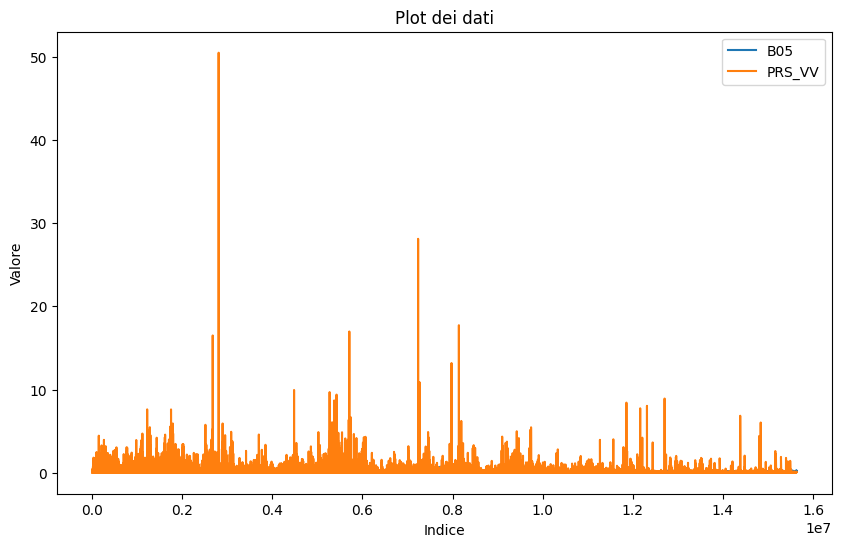

In [ ]:
descriptive_stats = df_normalized.describe()
print("\nStatistiche descrittive:")
print(descriptive_stats)

# Plotta i dati
plt.figure(figsize=(10, 6))
plt.plot(df_normalized['B05'], label='B05')
plt.plot(df_normalized['PRS_VV'], label='PRS_VV')
plt.xlabel('Indice')
plt.ylabel('Valore')
plt.title('Plot dei dati')
plt.legend()
plt.show()

In [ ]:
Q1 = df_normalized.quantile(0.05)
Q3 = df_normalized.quantile(0.95)
IQR = Q3 - Q1
outliers = ((df_normalized < (Q1 - 1.5 * IQR)) | (df_normalized > (Q3 + 1.5 * IQR))).any(axis=1)
Q1sec = secdf_normalized.quantile(0.05)
Q3sec = secdf_normalized.quantile(0.95)
secIQR = Q3sec - Q1sec
secoutliers = ((secdf_normalized < (Q1sec - 1.5 * secIQR)) | (secdf_normalized > (Q3sec + 1.5 * secIQR))).any(axis=1)
Q1ter = terdf_normalized.quantile(0.05)
Q3ter = terdf_normalized.quantile(0.95)
terIQR = Q3ter - Q1ter
teroutliers = ((terdf_normalized < (Q1ter - 1.5 * terIQR)) | (terdf_normalized > (Q3ter + 1.5 * terIQR))).any(axis=1)
Q1for = fordf_normalized.quantile(0.05)
Q3for = fordf_normalized.quantile(0.95)
forIQR = Q3for - Q1for
foroutliers = ((fordf_normalized < (Q1for - 1.5 * forIQR)) | (fordf_normalized > (Q3for + 1.5 * forIQR))).any(axis=1)
# Rimuovi gli outliers
df_no_outliers = df_normalized[~outliers]
# Identifica gli outliers
terdf_no_outliers = terdf_normalized[~teroutliers]
# Rimuovi gli outliers
secdf_no_outliers = secdf_normalized[~secoutliers]
fordf_no_outliers = fordf_normalized[~foroutliers]

In [ ]:
totdf_no_outliers = pd.concat([df_no_outliers, secdf_no_outliers,terdf_no_outliers,fordf_no_outliers,secdf_no_outliers,df_no_outliers], axis=0)
df_y = totdf_no_outliers['gedi']
df_x = totdf_no_outliers.drop(['gedi'], axis=1)
df_x.shape
df_y.shape

(739696,)

In [ ]:
split_pnt = int(df_x.shape[0] * 0.8) # consider 2/3 as the split point. 66.66 % for training set, and 0.33 % for test set.

xx_train = df_x.iloc[:split_pnt,:]
yy_train = df_y.iloc[:split_pnt]

xx_test = df_x.iloc[split_pnt:,:]
yy_test = df_y.iloc[split_pnt:]
xx_train.shape, xx_test.shape, yy_train.shape, yy_test.shape

((591756, 13), (147940, 13), (591756,), (147940,))

In [ ]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from joblib import parallel_backend
from scipy.stats import randint

In [ ]:
modello = RandomForestRegressor(n_estimators=150, max_depth=20, min_samples_split=15, random_state=42,verbose=10)
modello.fit(xx_train, yy_train)
#150,20,15

building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   11.4s


building tree 2 of 150
building tree 3 of 150
building tree 4 of 150


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   45.7s


building tree 5 of 150
building tree 6 of 150
building tree 7 of 150


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:  1.3min


building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:  2.3min


building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:  3.3min


building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:  4.7min


building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:  6.1min


building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  7.8min


building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150
building tree 45 of 150
building tree 46 of 150
building tree 47 of 150
building tree 48 of 150
building tree 49 of 150


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  9.6min


building tree 50 of 150
building tree 51 of 150
building tree 52 of 150
building tree 53 of 150
building tree 54 of 150
building tree 55 of 150
building tree 56 of 150
building tree 57 of 150
building tree 58 of 150
building tree 59 of 150
building tree 60 of 150


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed: 11.7min


building tree 61 of 150
building tree 62 of 150
building tree 63 of 150
building tree 64 of 150
building tree 65 of 150
building tree 66 of 150
building tree 67 of 150
building tree 68 of 150
building tree 69 of 150
building tree 70 of 150
building tree 71 of 150


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed: 13.9min


building tree 72 of 150
building tree 73 of 150
building tree 74 of 150
building tree 75 of 150
building tree 76 of 150
building tree 77 of 150
building tree 78 of 150
building tree 79 of 150
building tree 80 of 150
building tree 81 of 150
building tree 82 of 150
building tree 83 of 150
building tree 84 of 150


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed: 16.4min


building tree 85 of 150
building tree 86 of 150
building tree 87 of 150
building tree 88 of 150
building tree 89 of 150
building tree 90 of 150
building tree 91 of 150
building tree 92 of 150
building tree 93 of 150
building tree 94 of 150
building tree 95 of 150
building tree 96 of 150
building tree 97 of 150


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed: 18.9min


building tree 98 of 150
building tree 99 of 150
building tree 100 of 150
building tree 101 of 150
building tree 102 of 150
building tree 103 of 150
building tree 104 of 150
building tree 105 of 150
building tree 106 of 150
building tree 107 of 150
building tree 108 of 150
building tree 109 of 150
building tree 110 of 150
building tree 111 of 150
building tree 112 of 150


[Parallel(n_jobs=1)]: Done 112 tasks      | elapsed: 22.0min


building tree 113 of 150
building tree 114 of 150
building tree 115 of 150
building tree 116 of 150
building tree 117 of 150
building tree 118 of 150
building tree 119 of 150
building tree 120 of 150
building tree 121 of 150
building tree 122 of 150
building tree 123 of 150
building tree 124 of 150
building tree 125 of 150
building tree 126 of 150
building tree 127 of 150


[Parallel(n_jobs=1)]: Done 127 tasks      | elapsed: 25.5min


building tree 128 of 150
building tree 129 of 150
building tree 130 of 150
building tree 131 of 150
building tree 132 of 150
building tree 133 of 150
building tree 134 of 150
building tree 135 of 150
building tree 136 of 150
building tree 137 of 150
building tree 138 of 150
building tree 139 of 150
building tree 140 of 150
building tree 141 of 150
building tree 142 of 150
building tree 143 of 150
building tree 144 of 150


[Parallel(n_jobs=1)]: Done 144 tasks      | elapsed: 28.9min


building tree 145 of 150
building tree 146 of 150
building tree 147 of 150
building tree 148 of 150
building tree 149 of 150
building tree 150 of 150


RandomForestRegressor(max_depth=20, min_samples_split=15, n_estimators=150,
                      random_state=42, verbose=10)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    4.7s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    7.1s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    8.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:   10.1s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:   11.8s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:   13.8s
[Parallel(n_jobs=1)]: Done 112 tasks      | elapsed:   16.2s
[Parallel(n_jobs=1)]: Done 127 tasks      | elapsed:   18.4s
[Parallel(n_jobs=1)]: Done 144 tasks      | elapsed:   20.6s


Train Mean Squared Error: 731.6436
Train R² Score: 0.7889
Root Mean Squared Error: 27.04891131104517
Mean Absolute Error: 15.166072636106865


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done 112 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done 127 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 144 tasks      | elapsed:    5.6s


Test Mean Squared Error: 1645.4496
Test R² Score: 0.6839
Root Mean Squared Error: 40.564141552174775
Mean Absolute Error: 26.608200051409526
      Feature  Importance
12     canopy    0.494199
11      slope    0.138701
10  elevation    0.053923
0         B04    0.039345
6         EVI    0.035922
9      PRS_VH    0.035849
8      PRS_VV    0.035085
1         B05    0.033607
3         B11    0.028304
7        NDII    0.028266
4         B12    0.026627
5        NDVI    0.026065
2         B08    0.024107


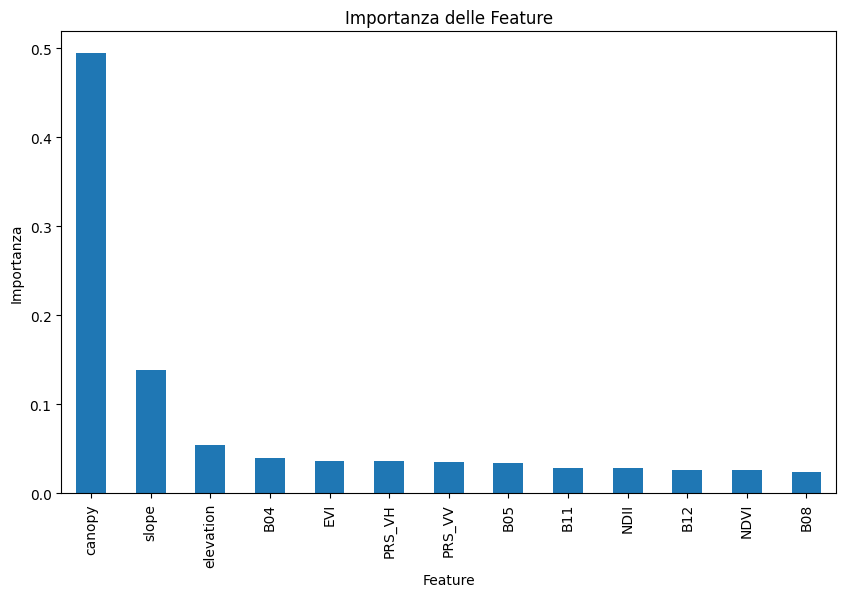

In [ ]:
from sklearn import metrics
y_train_pred = modello.predict(xx_train)

# Calcolare le metriche di valutazione
train_mse = mean_squared_error(yy_train, y_train_pred)
train_r2 = r2_score(yy_train, y_train_pred)

print(f'Train Mean Squared Error: {train_mse:.4f}')
print(f'Train R² Score: {train_r2:.4f}')
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yy_train, y_train_pred)))
print('Mean Absolute Error:', metrics.mean_absolute_error(yy_train, y_train_pred))

y_test_pred = modello.predict(xx_test)

# Calcolare le metriche di valutazione
test_mse = mean_squared_error(yy_test, y_test_pred)
test_r2 = r2_score(yy_test, y_test_pred)

print(f'Test Mean Squared Error: {test_mse:.4f}')
print(f'Test R² Score: {test_r2:.4f}')
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yy_test, y_test_pred)))
print('Mean Absolute Error:', metrics.mean_absolute_error(yy_test, y_test_pred))
# Estrarre l'importanza delle caratteristiche
feature_importances = modello.feature_importances_

# Creare un dataframe per visualizzare l'importanza delle feature
features = xx_train.columns
importances = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Ordinare per importanza
importances = importances.sort_values(by='Importance', ascending=False)

# Visualizzare
print(importances)

# Tracciare l'importanza delle feature
importances.plot(kind='bar', x='Feature', y='Importance', legend=False, figsize=(10, 6))
plt.title('Importanza delle Feature')
plt.ylabel('Importanza')
plt.show()

In [ ]:
import joblib # In older scikit-learn versions use 'sklearn.externals'

joblib.dump(modello, 'random_forest.pkl')

['random_forest.pkl']

In [ ]:
import joblib
model = joblib.load('/content/drive/MyDrive/RF_AGB/random_forest.pkl')


In [ ]:
file_path = "/content/drive/MyDrive/mergedCollection5.tif"

with rasterio.open(file_path) as src:
    # Lettura dei dati di ciascuna banda
    for band_num in range(1, src.count + 1):
        # Lettura dei dati della banda specifica
        band_data = src.read(band_num)
        # Creazione del nome del file per la banda
        band_file_name = f"5banda_{band_num}.npy"
        # Salvataggio dell'array della banda come file NumPy
        np.save(band_file_name, band_data)

fivefile_names = ["5banda_1.npy", "5banda_2.npy", "5banda_3.npy","5banda_4.npy","5banda_5.npy","5banda_6.npy","5banda_7.npy",
              "5banda_8.npy", "5banda_9.npy", "5banda_10.npy","5banda_11.npy","5banda_12.npy","5banda_13.npy",
              "5banda_14.npy"]  # Aggiungi tutti i nomi dei file NumPy

# Lista per salvare gli array NumPy delle bande
fiveband_arrays = []

In [ ]:
# Itera attraverso i nomi dei file
for file_name in fivefile_names:
    # Carica l'array NumPy utilizzando np.load()
    band_data = np.load("/content/" + file_name)  # Assicurati di specificare il percorso corretto
    # Aggiungi l'array alla lista delle bande
    fiveband_arrays.append(band_data)
fivefeatures = {
    'B04':fiveband_arrays[0].flatten(),
    'B05' : fiveband_arrays[1].flatten(),
  'B08' : fiveband_arrays[2].flatten(),
  'B11' : fiveband_arrays[3].flatten(),
  'B12' : fiveband_arrays[4].flatten(),
  'NDVI' : fiveband_arrays[5].flatten(),
  'EVI' : fiveband_arrays[6].flatten(),
  'NDII' : fiveband_arrays[7].flatten(),
  'PRS_VV' : fiveband_arrays[8].flatten(),
  'PRS_VH': fiveband_arrays[9].flatten(),
  'elevation': fiveband_arrays[10].flatten(),
  'slope' : fiveband_arrays[11].flatten(),
  'canopy' : fiveband_arrays[12].flatten(),
  'gedi':fiveband_arrays[13].flatten()
}

df5 = pd.DataFrame(fivefeatures)
df5= df5.dropna()
# Seleziona solo le colonne che desideri normalizzare
columns_to_normalize = [ 'elevation', 'slope']

# Crea un oggetto StandardScaler
scaler = MinMaxScaler()

# Normalizza le colonne selezionate
fivedf_normalized = df5.copy()  # Copia il dataframe originale per evitare modifiche indesiderate
fivedf_normalized[columns_to_normalize] = scaler.fit_transform(fivedf_normalized[columns_to_normalize])
Q1 = fivedf_normalized.quantile(0.05)
Q3 = fivedf_normalized.quantile(0.95)
IQR = Q3 - Q1
fiveoutliers = ((fivedf_normalized < (Q1 - 1.5 * IQR)) | (fivedf_normalized > (Q3 + 1.5 * IQR))).any(axis=1)

# Rimuovi gli outliers
fivedf_no_outliers = fivedf_normalized[~fiveoutliers]
fivedf_y = fivedf_no_outliers['gedi']
fivedf_x = fivedf_no_outliers.drop(['gedi'], axis=1)

y_predette = model.predict(fivedf_x)
mse = mean_squared_error(fivedf_y, y_predette)
r2 = r2_score(fivedf_y, y_predette)

print(f'Train Mean Squared Error: {mse:.4f}')
print(f'Train R² Score: {r2:.4f}')
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(fivedf_y, y_predette)))
print('Mean Absolute Error:', metrics.mean_absolute_error(fivedf_y, y_predette))


NameError: name 'fivefile_names' is not defined

In [ ]:
file_path = "/content/drive/MyDrive/mergedCollection5.tif"
with rasterio.open(file_path) as src:
    img = src.read()  # Questo legge tutte le bande dell'immagine
    profile = src.profile

In [ ]:
def handle_nan(img):
    # Sostituisci NaN con la media della banda
    for i in range(img.shape[0]):  # iterare su ciascuna banda
        nan_mask = np.isnan(img[i])
        if np.any(nan_mask):
            mean_value = np.nanmean(img[i])
            img[i][nan_mask] = mean_value
    return img
# Gestire i valori NaN
img = handle_nan(img)
img = np.delete(img, 13, axis=0)
# Trasporre l'immagine in modo che ogni pixel sia una riga e ogni banda sia una colonna
bands, height, width = img.shape
img_reshaped = img.reshape(bands, -1).T

# Caricare il modello

# Fare previsioni sui dati dell'immagine
predictions = model.predict(img_reshaped)

# Rimodellare le previsioni alla forma originale dell'immagine
predicted_image = predictions.reshape(height, width)

# Aggiornare il profilo per riflettere una singola banda di output
profile.update(dtype=rasterio.float32, count=1)

# Salvare l'immagine predetta come TIFF
predicted_image_path = 'predicted_image.tiff'
with rasterio.open(predicted_image_path, 'w', **profile) as dst:
    dst.write(predicted_image.astype(rasterio.float32), 1)

# Visualizzare l'immagine con geemap
 # Sostituire lat, lon e zoom_level con i valori appropriati



[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   12.6s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:   22.5s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:   39.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   56.3s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  2.1min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.5min
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:  3.1min
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:  3.7min
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:  4.3min
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:  5.0min
[Parallel(n_jobs=1)]: Done 112 tasks      | elapsed:  5.8min
[Parallel(n_jobs=1)]: Done 127 tasks      | elapsed:  6.5min
[Parallel(n_jobs=1)]: Done 144 tasks      | elapsed:  7.3min


In [ ]:
with rasterio.open(predicted_image_path, 'w', **profile) as dst:
    dst.write(predicted_image.astype(rasterio.float32), 1)

In [ ]:
file_path = "/content/predicted_image.tiff"
with rasterio.open(file_path) as src:
    img = src.read()

In [ ]:
prediction_image =(img)
vis_params = { 'palette': ['#440154', ' #440256', ' #450457', ' #450559', ' #46075a', ' #46085c', ' #460a5d', ' #460b5e', ' #470d60', ' #470e61', ' #471063', ' #471164', ' #471365', ' #481467', ' #481668', ' #481769', ' #48186a', ' #481a6c', ' #481b6d', ' #481c6e', ' #481d6f', ' #481f70', ' #482071', ' #482173', ' #482374', ' #482475', ' #482576', ' #482677', ' #482878', ' #482979', ' #472a7a', ' #472c7a', ' #472d7b', ' #472e7c', ' #472f7d', ' #46307e', ' #46327e', ' #46337f', ' #463480', ' #453581', ' #453781', ' #453882', ' #443983', ' #443a83', ' #443b84', ' #433d84', ' #433e85', ' #423f85', ' #424086', ' #424186', ' #414287', ' #414487', ' #404588', ' #404688', ' #3f4788', ' #3f4889', ' #3e4989', ' #3e4a89', ' #3e4c8a', ' #3d4d8a', ' #3d4e8a', ' #3c4f8a', ' #3c508b', ' #3b518b', ' #3b528b', ' #3a538b', ' #3a548c', ' #39558c', ' #39568c', ' #38588c', ' #38598c', ' #375a8c', ' #375b8d', ' #365c8d', ' #365d8d', ' #355e8d', ' #355f8d', ' #34608d', ' #34618d', ' #33628d', ' #33638d', ' #32648e', ' #32658e', ' #31668e', ' #31678e', ' #31688e', ' #30698e', ' #306a8e', ' #2f6b8e', ' #2f6c8e', ' #2e6d8e', ' #2e6e8e', ' #2e6f8e', ' #2d708e', ' #2d718e', ' #2c718e', ' #2c728e', ' #2c738e', ' #2b748e', ' #2b758e', ' #2a768e', ' #2a778e', ' #2a788e', ' #29798e', ' #297a8e', ' #297b8e', ' #287c8e', ' #287d8e', ' #277e8e', ' #277f8e', ' #27808e', ' #26818e', ' #26828e', ' #26828e', ' #25838e', ' #25848e', ' #25858e', ' #24868e', ' #24878e', ' #23888e', ' #23898e', ' #238a8d', ' #228b8d', ' #228c8d', ' #228d8d', ' #218e8d', ' #218f8d', ' #21908d', ' #21918c', ' #20928c', ' #20928c', ' #20938c', ' #1f948c', ' #1f958b', ' #1f968b', ' #1f978b', ' #1f988b', ' #1f998a', ' #1f9a8a', ' #1e9b8a', ' #1e9c89', ' #1e9d89', ' #1f9e89', ' #1f9f88', ' #1fa088', ' #1fa188', ' #1fa187', ' #1fa287', ' #20a386', ' #20a486', ' #21a585', ' #21a685', ' #22a785', ' #22a884', ' #23a983', ' #24aa83', ' #25ab82', ' #25ac82', ' #26ad81', ' #27ad81', ' #28ae80', ' #29af7f', ' #2ab07f', ' #2cb17e', ' #2db27d', ' #2eb37c', ' #2fb47c', ' #31b57b', ' #32b67a', ' #34b679', ' #35b779', ' #37b878', ' #38b977', ' #3aba76', ' #3bbb75', ' #3dbc74', ' #3fbc73', ' #40bd72', ' #42be71', ' #44bf70', ' #46c06f', ' #48c16e', ' #4ac16d', ' #4cc26c', ' #4ec36b', ' #50c46a', ' #52c569', ' #54c568', ' #56c667', ' #58c765', ' #5ac864', ' #5cc863', ' #5ec962', ' #60ca60', ' #63cb5f', ' #65cb5e', ' #67cc5c', ' #69cd5b', ' #6ccd5a', ' #6ece58', ' #70cf57', ' #73d056', ' #75d054', ' #77d153', ' #7ad151', ' #7cd250', ' #7fd34e', ' #81d34d', ' #84d44b', ' #86d549', ' #89d548', ' #8bd646', ' #8ed645', ' #90d743', ' #93d741', ' #95d840', ' #98d83e', ' #9bd93c', ' #9dd93b', ' #a0da39', ' #a2da37', ' #a5db36', ' #a8db34', ' #aadc32', ' #addc30', ' #b0dd2f', ' #b2dd2d', ' #b5de2b', ' #b8de29', ' #bade28', ' #bddf26', ' #c0df25', ' #c2df23', ' #c5e021', ' #c8e020', ' #cae11f', ' #cde11d', ' #d0e11c', ' #d2e21b', ' #d5e21a', ' #d8e219', ' #dae319', ' #dde318', ' #dfe318', ' #e2e418', ' #e5e419', ' #e7e419', ' #eae51a', ' #ece51b', ' #efe51c', ' #f1e51d', ' #f4e61e', ' #f6e620', ' #f8e621', ' #fbe723', ' #fde725'], 'min': 2.0, 'max': 167.0, 'opacity': 1.0}


Map.add_raster(prediction_image, vis_params, layer_name="predicted Image")
Map

ValueError: cellsize must be provided if source is not provided